# Model Tuning
---

### Import Packages

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import warnings

import params as p
import functions as f

from xgboost import XGBRegressor

from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import r2_score

import optuna
from optuna.integration import OptunaSearchCV
from optuna.distributions import IntUniformDistribution, UniformDistribution, LogUniformDistribution, CategoricalDistribution

/opt/anaconda3/envs/data_analytics/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


### Settings

In [2]:
warnings.simplefilter(action='ignore', category = FutureWarning)

### Import Data

In [3]:
# Load train, test and validation datasets
train, test, val = f.load_split_datasets(part = '03')

In [4]:
# Split datasets into X and y components
X_train, y_train = f.split_data_X_y(train)
X_test, y_test = f.split_data_X_y(test)
X_val, y_val = f.split_data_X_y(val)

In [5]:
# Define train/test/validation dictionaries to make fitting and evaluation arguments cleaner
train_data = {'X' : X_train, 'y' : y_train}
test_data = {'X' : X_test, 'y' : y_test}
val_data = {'X' : X_val, 'y' : y_val}

### Create Initial Models

In [6]:
print('lr model...', end = ' ')
lr = LinearRegression().fit(**train_data)
print('trained')

print('xgb model...', end = ' ')
xgb = XGBRegressor(random_state = p.RANDOM_STATE).fit(**train_data)
print('trained')

print('rf model...', end = ' ')
rf = RandomForestRegressor(random_state=p.RANDOM_STATE).fit(**train_data)
print('trained')

print('nb model...', end = ' ')
nb = GaussianNB().fit(**train_data)
print('trained')

lr model... trained
xgb model... trained
rf model... trained
nb model... trained


### Evaluate Initial Models on Validation Data

In [7]:
models = [lr, xgb, rf, nb]

rmse_initial_results = {
    'Model' : ['Linear Regresssion', 'XGBoost', 'RandomForest', 'Naive Bayes'],
    'R2 Train' : [f.evaluate_model(model, metric = 'r2', **train_data) for model in models],
    'R2 Test' : [f.evaluate_model(model, metric = 'r2', **test_data) for model in models]
    }
initial_results = pd.DataFrame(rmse_initial_results)
initial_results

,Model,R2 Train,R2 Test
0,Linear Regresssion,0.567670,0.551524
1,XGBoost,0.986061,0.910505
2,RandomForest,0.983250,0.883622
3,Naive Bayes,0.626994,0.317068


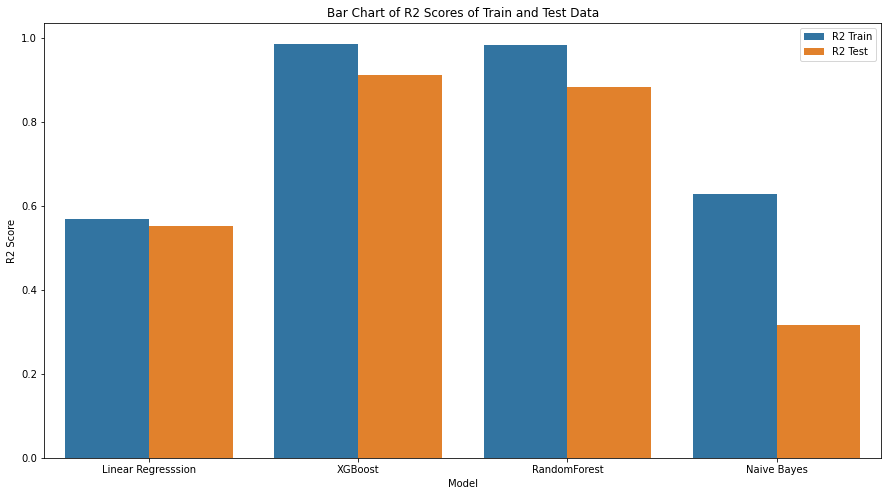

In [8]:
fig, ax = plt.subplots(1, 1, figsize = (15, 8))

melt_data = initial_results.melt(id_vars = 'Model')

sns.barplot(
    ax = ax,
    data = melt_data,
    x = 'Model',
    y = 'value',
    hue = 'variable').set(title = 'Bar Chart of R2 Scores of Train and Test Data')

plt.ylabel('R2 Score')
plt.legend()
plt.show()

1. The Linear Regression model does show a reasonable performance and, since we cannot tune it, will provide a good baseline to compare our initial results against.

1. We can see that the XGBoost model does seem to have the best performance currently with R2 scores of 0.986061 and 0.910505 from train and test respectively. However, the RandomForest model does show similar R2, albeit slightly lower. Since these are the two models that are more open to extensive tuning, initial results show that the most appropriate model will be one of these. Comparing these models to our baseline, we can see that we have already got more value out changing the model before tuning.

1. Our Naive Bayes Model is already showing signs of over fitting with the train R2 score an improvement on our baseline score. It will be worth tuning this model to see if we can get anything more out of it, but initial results point to one of the tree-based models.

### Model Tuning - Optuna

We will be using the optuna framework to train our models due to the improved performance on sklearn's `RandomizedSearchCV` and the nice structure optuna brings.

1. We start with the XGBoost tuning, breaking it down into three sections: Tree-based parameters, Regularization Parameters and Learning Rate. We will use a separate optuna study for each section to effectively tune the model and avoid over fitting. Tree-based parameters include `max_depth`, `min_child_weight`, `n_estimators`, `subsample`, `gamma` and `colsample_by_tree`; Regularization parameters include `alpha` and `lambda` to focus on over fitting control; and the final section just looks at finding the optimal `learning_rate` based on the other optimal parameters.

1. Since all the RandomForest parameters fall into the same category, we can use a single optuna study to tune this model. The parameters that we will be tuning are the following: `max_depth`, `max_features`, `n_estimators`, `bootstrap`, `min_samples_leaf` and `min_samples_split`.

1. The final model to tune is the Naive Bayes model which only requires tuning of `var_smoothing` which helps control over fitting.

### XGB Tuning

In [9]:
xgb_base_params = {
    'verbosity' : 0,
    'n_jobs' : -1,
    'random_state' : p.RANDOM_STATE,
    }

xgb_optuna_base = XGBRegressor(**xgb_base_params)

In [10]:
xgb_oscv_params = {
    'max_depth' : IntUniformDistribution(2, 5),
    'min_child_weight' : IntUniformDistribution(5, 10),
    'n_estimators' : IntUniformDistribution(50, 1000),
    'subsample' : UniformDistribution(0.1, 1),
    'gamma' : LogUniformDistribution(1e-2, 10.0),
    'colsample_bytree' : UniformDistribution(0.1, 1),
    'lambda' : LogUniformDistribution(1e-2, 10.0),
    'alpha' : LogUniformDistribution(1e-2, 10.0),
    'learning_rate' : CategoricalDistribution([0.01, 0.03, 0.1, 0.3, 1])
    }

xgb_oscv = OptunaSearchCV(
    estimator = xgb_optuna_base,
    param_distributions = xgb_oscv_params,
    cv = 10,
    n_jobs = -1,
    n_trials = 200,
    random_state = p.RANDOM_STATE,
    refit = True,
    scoring = 'r2',
    return_train_score = True,
    verbose = 2
)

fit_params = {
    'eval_metric' : 'rmse',
    'eval_set' : [(X_train, y_train), (X_test, y_test)],
    'early_stopping_rounds' : 10,
    'verbose' : 0
    }

xgb_oscv.fit(X_train, y_train, **fit_params)

/var/folders/2f/cwgmhyzx4fn5cwp5j_dpmsd00000gn/T/ipykernel_58737/3802962956.py:13: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  xgb_oscv = OptunaSearchCV(
[I 2022-04-05 12:19:26,512] A new study created in memory with name: no-name-477865dc-439a-4186-871f-305820e0bce6
[I 2022-04-05 12:19:26,513] Searching the best hyperparameters using 5083 samples...
[I 2022-04-05 12:19:45,356] Trial 4 finished with value: 0.844107656871232 and parameters: {'max_depth': 2, 'min_child_weight': 7, 'n_estimators': 382, 'subsample': 0.3688100482842539, 'gamma': 0.12376894410473852, 'colsample_bytree': 0.8700553642978074, 'lambda': 0.34391330315363317, 'alpha': 0.2556577391898974, 'learning_rate': 0.3}. Best is trial 4 with value: 0.844107656871232.
[I 2022-04-05 12:20:07,721] Trial 0 finished with value: 0.8568133360443755 and parameters: {'max_depth': 4, 'min_child_weight': 8, 'n_estimators': 370, 'subsample': 0.8389908285271503, 

In [ ]:
# return train plots ...

In [ ]:
xgb_tuned = xgb_oscv.best_estimator_

In [ ]:
model = xgb_tuned
print('Train R2:', f.evaluate_model(model, metric = 'r2', **train_data))
print('Test R2:', f.evaluate_model(model, metric = 'r2', **test_data))

Train R2: 0.953055
Test R2: 0.905031


Our model still seems a little over fit so we will reduce `max_depth` manually to see if that has a positive effect on our results.

In [ ]:
xgb_test_params = xgb_oscv.best_params_
test_results = {'max_depth' : [5, 4, 3, 2], 'train' : [], 'test' : []}

for md in test_results['max_depth']:

    xgb_test_params['max_depth'] = md

    xgb_test_model = XGBRegressor(**xgb_test_params)
    xgb_test_model.fit(X_train, y_train, **fit_params)

    test_results['train'].append(f.evaluate_model(xgb_test_model, metric = 'r2', **train_data))
    test_results['test'].append(f.evaluate_model(xgb_test_model, metric = 'r2', **test_data))

test_results = pd.DataFrame(test_results, )

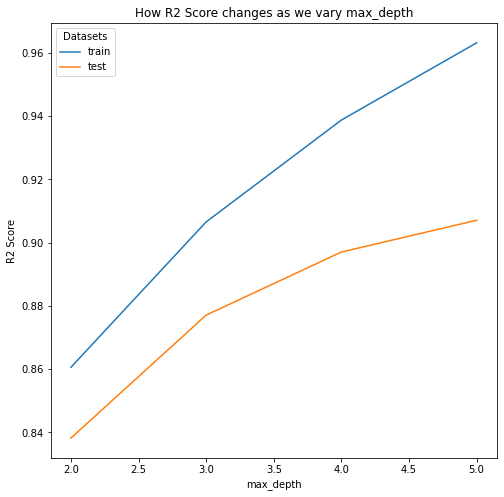

In [ ]:
fig, ax = plt.subplots(1, 1, figsize = (8, 8))

sns.lineplot(x='max_depth', y='r2_score', hue='Datasets', data = test_results.melt('max_depth', var_name = 'Datasets', value_name = 'r2_score'), ax = ax)

plt.ylabel('R2 Score')
plt.title('How R2 Score changes as we vary max_depth')
plt.show()

We can see from the above plot that a more appropriate choice would be taking a `max_depth` of 3 since the difference between the train and test lines becomes more constant. Whereby the reduction in difference from `max_depth` = 3 to `max_depth` = 2 does not justify the reduction in performance.

#### Final, Tuned XGB Model

In [ ]:
xgb_tuned_params = xgb_oscv.best_params_
xgb_tuned_params['max_depth'] = 3

In [ ]:
xgb_tuned = XGBRegressor(**xgb_tuned_params)
xgb_tuned.fit(X_train, y_train, **fit_params)

XGBRegressor(alpha=7.054795227253422, base_score=0.5, booster='gbtree',
             colsample_bylevel=1, colsample_bynode=1,
             colsample_bytree=0.904265670776958, enable_categorical=False,
             gamma=0.07628450229148089, gpu_id=-1, importance_type=None,
             interaction_constraints='', lambda=4.970547573837211,
             learning_rate=0.03, max_delta_step=0, max_depth=3,
             min_child_weight=8, missing=nan, monotone_constraints='()',
             n_estimators=949, n_jobs=8, num_parallel_tree=1, predictor='auto',
             random_state=0, reg_alpha=7.05479527, reg_lambda=4.97054768,
             scale_pos_weight=1, subsample=0.8288767800730592,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [ ]:
print('Train R2:', f.evaluate_model(xgb_tuned, metric = 'r2', **train_data))
print('Test R2:', f.evaluate_model(xgb_tuned, metric = 'r2', **test_data))

Train R2: 0.906573
Test R2: 0.877099


Although these R2 scores are lower then the baseline xgboost R2 scores, we have such an improvement in the fit of the model. Where the model was massively over fit previously, we now have a much tigher model.

### RandomForest Model Tuning

As mentioned, since the RandomForest hyperparameters are tree-based, we can tune them all with a single study. The parameters we will be tuning are the following: `max_depth`, `max_features`, `n_estimators`, `bootstrap`, `min_samples_leaf` and `min_samples_split`.

In [ ]:
rf_base_params = {
    'verbose' : 0,
    'random_state' : p.RANDOM_STATE,
    }

rf_optuna_base = RandomForestRegressor(**rf_base_params)

In [ ]:
rf_oscv_params = {
    'max_depth' : IntUniformDistribution(2, 6),
    'max_features' : CategoricalDistribution(['auto', 'sqrt']),
    'n_estimators' : IntUniformDistribution(50, 1000),
    'bootstrap' : CategoricalDistribution([True, False]),
    'min_samples_leaf' : UniformDistribution(0, 0.5),
    'min_samples_split' : UniformDistribution(0, 0.5),
    }

rf_oscv = OptunaSearchCV(
    estimator = rf_optuna_base,
    param_distributions = rf_oscv_params,
    cv = 10,
    n_jobs = -1,
    n_trials = 200,
    random_state = p.RANDOM_STATE,
    refit = True,
    scoring = 'r2',
    return_train_score = True,
    verbose = 2
)

rf_oscv.fit(X_train, y_train)

/var/folders/2f/cwgmhyzx4fn5cwp5j_dpmsd00000gn/T/ipykernel_52296/1192181424.py:10: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  rf_oscv = OptunaSearchCV(
[I 2022-04-05 00:04:20,756] A new study created in memory with name: no-name-3e2f69f3-ae1e-47b1-b12d-f6c49a3f41a7
[I 2022-04-05 00:04:20,756] Searching the best hyperparameters using 5083 samples...
[I 2022-04-05 00:04:32,217] Trial 2 finished with value: 0.276776497910051 and parameters: {'max_depth': 2, 'max_features': 'auto', 'n_estimators': 147, 'bootstrap': False, 'min_samples_leaf': 0.35765966350294265, 'min_samples_split': 0.4652204984724965}. Best is trial 2 with value: 0.276776497910051.
[I 2022-04-05 00:04:43,499] Trial 3 finished with value: -0.0013485523528857346 and parameters: {'max_depth': 4, 'max_features': 'auto', 'n_estimators': 498, 'bootstrap': True, 'min_samples_leaf': 0.32567591863492534, 'min_samples_split': 0.28352534366471177}. Best is 

OptunaSearchCV(cv=10, estimator=RandomForestRegressor(random_state=73),
               n_jobs=-1, n_trials=200,
               param_distributions={'bootstrap': CategoricalDistribution(choices=(True, False)),
                                    'max_depth': IntUniformDistribution(high=6, low=2, step=1),
                                    'max_features': CategoricalDistribution(choices=('auto', 'sqrt')),
                                    'min_samples_leaf': UniformDistribution(high=0.5, low=0.0),
                                    'min_samples_split': UniformDistribution(high=0.5, low=0.0),
                                    'n_estimators': IntUniformDistribution(high=1000, low=50, step=1)},
               random_state=73, return_train_score=True, scoring='r2',
               verbose=2)

In [ ]:
# return train plots ...

In [ ]:
rf_tuned = rf_oscv.best_estimator_

In [ ]:
print('Train R2:', f.evaluate_model(rf_tuned, metric = 'r2', **train_data))
print('Test R2:', f.evaluate_model(rf_tuned, metric = 'r2', **test_data))

Train R2: 0.890742
Test R2: 0.842816


R2 scores of 0.797747 and 0.756056 on our train and test data respectively. This is a substantial change to our initial RandomForest model; however, we have eliminated the massive over fitting that was being performed at the initial modelling stage. We will look at how our model performs on our validation data and compare it to other models.

### Naive Bayes Model Tuning

We use another optuna study to find the best value of `var_smoothing` for the performance of our Naive Bayes model.

In [ ]:
nb_oscv_params = {
    'var_smoothing' : LogUniformDistribution(1e-5, 5),
    }

nb_oscv = OptunaSearchCV(
    estimator = GaussianNB(),
    param_distributions = nb_oscv_params,
    cv = 10,
    n_jobs = -1,
    n_trials = 200,
    random_state = p.RANDOM_STATE,
    refit = True,
    scoring = 'r2',
    return_train_score = True,
    enable_pruning = True,
    verbose = 2
)

nb_oscv.fit(X_train, y_train)

[I 2022-04-05 09:02:17,354] A new study created in memory with name: no-name-3dcd6c29-f725-4035-b097-a78e0c33abcf
/opt/anaconda3/envs/data_analytics/lib/python3.9/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"
[I 2022-04-05 09:02:38,509] Trial 7 finished with value: -0.8532439906096835 and parameters: {'var_smoothing': 0.28142415998421944}. Best is trial 7 with value: -0.8532439906096835.
/opt/anaconda3/envs/data_analytics/lib/python3.9/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"
[I 2022-04-05 09:02:38,843] Trial 4 finished with value: 0.3360396317520505 and parameters: {'var_smoothing': 1.691036579184226e-05}. Best is trial 4 with value: 0.3360396317520505.
/o

In [ ]:
# return train plots ...

In [ ]:
nb_tuned = nb_oscv.best_estimator_

In [ ]:
print('Train R2:', f.evaluate_model(nb_tuned, metric = 'r2', **train_data))
print('Test R2:', f.evaluate_model(nb_tuned, metric = 'r2', **test_data))

Train R2: 0.518477
Test R2: 0.38964


With train and test R2 scores of 0.518477 and 0.38964 respectively, it does not look like this model is the appropriate one for this problem. However, we will look at how it performs on our validation data and make a decision in comparison to the other models.

### Evaluate Final, Tuned Models on validation data

In [ ]:
tuned_models = [lr, xgb_tuned, rf_tuned, nb_tuned]

tuned_rmse = {
    'R2 Train' : [f.evaluate_model(model, metric = 'r2', **train_data) for model in tuned_models],
    'R2 Test' : [f.evaluate_model(model, metric = 'r2', **test_data) for model in tuned_models],
    'R2 Validation' : [f.evaluate_model(model, metric = 'r2', **val_data) for model in tuned_models]
    }
    
pd_rmse = pd.DataFrame(tuned_rmse, index = ['Linear Regression', 'Tuned XGBoost', 'Tuned RandomForest', 'Tuned Naive Bayes'])
pd_rmse

,r2_train,r2_test,r2_val
Linear Regression,0.567670,0.551524,0.537439
Tuned XGBoost,0.904754,0.873853,0.871559
Tuned RandomForest,0.890742,0.842816,0.848896
Tuned Naive Bayes,0.518477,0.389640,0.372139


Looking at these R2 scores, it looks like the Tuned XGBoost model is the appropriate model for this problem due to it having the highest validation R2 score, close train and test R2 scores suggesting minimal over fitting, and high R2 scores in general for each dataset.

#### Make Plot to show Residuals for each model

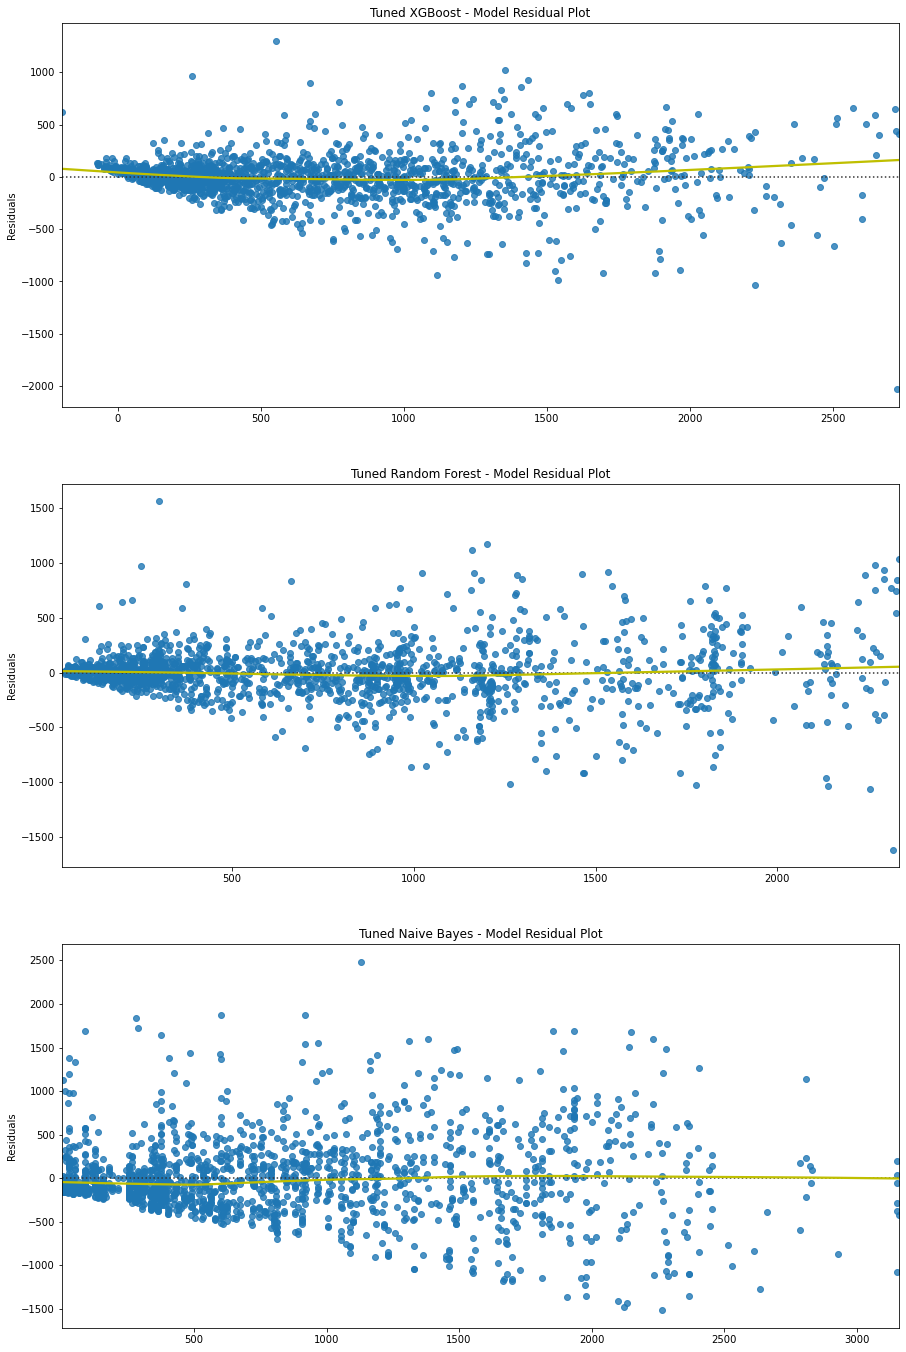

In [ ]:
def make_residual_plot():

    fig, ax = plt.subplots(nrows = 3, ncols = 1, figsize=(15, 24))

    for idx, model_info in enumerate([('Tuned XGBoost', xgb_tuned), ('Tuned Random Forest', rf_tuned), ('Tuned Naive Bayes', nb_tuned)]):

        model_name = model_info[0]
        model = model_info[1]

        sns.residplot(
            ax = ax[idx],
            x = model.predict(X_val),
            y = y_val,
            lowess = True,
            line_kws = {'color' : 'y'},
        ).set(title = f'{model_name} - Model Residual Plot', ylabel = 'Residuals')

    plt.savefig(p.OUTPUTS_PATH + 'residuals1.png')
    plt.show()

make_residual_plot()

As we can from the residual plots above, the Tuned XGBoost model has residuals closest to the y = 0 line. It looks like the residuals are larger at the extremities.... unexplained variance.

### Plot Histogram of Results

In [ ]:
def display_dual_histograms():

    fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize = (24, 8))

    for idx, model_info in enumerate([('Tuned XGBoost', xgb_tuned), ('Tuned Random Forest', rf_tuned), ('Tuned Naive Bayes', nb_tuned)]):

        model_name = model_info[0]
        model = model_info[1]

        for x in [y_val, model.predict(X_val)]:
            sns.distplot(x, bins = 100, ax=ax[idx], kde = False).set(title = f'{model_name} Model - Histogram')

    plt.show()

display_dual_histograms()

### Save the best model

In [ ]:
f.save_model_and_preds(xgb_tuned, model_name = 'best', X = X_val)